In [1]:
import os
import torch

save_dir = os.path.expanduser("~/YOLO_MODELS")
checkpoint_pth = save_dir + "/" + max([f for f in os.listdir(save_dir) if f.endswith(".pth")])

In [2]:
from models import YOLOv1
from data.VOC_Dataset import VOC_Dataset
from data import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [3]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 1
class_dict =  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
class_dict = {v:k for k, v in class_dict.items()}

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

class dict:  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


In [4]:
yolo = YOLOv1().to(device=device)
yolo.load_state_dict(torch.load(checkpoint_pth)["model"])
# set_trace()
S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

C:\Users\sxing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sxing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
from utils.display import display_image_bbox
from utils.metrics import xywh_2_xxyy, IOU
import numpy as np

with torch.no_grad():
    for _, (batch, labels, classes) in enumerate(loader):
        res = yolo(batch.to(device=device)).squeeze(0)
        # set_trace()
        boxes = []
        labels_map = {}
        for i in range(res.shape[1]):
            for j in range(res.shape[2]):
                cell1 = res[:, i, j][:5]
                cell2 = res[:, i, j][5:10]
                boxes.append(cell1.detach().cpu().numpy())
                boxes.append(cell2.detach().cpu().numpy())
                labels_map[(i, j)] = res[:, i, j][-20:]

        # non-max suppression
        lo = 0
        while lo < len(boxes):
            del_inds = set()
            for j in range(lo+1, len(boxes)):
                if IOU(boxes[lo], boxes[j]) > 0.2:
                    if boxes[lo][4] > boxes[j][4]:
                        del_inds.add(j)
                    else:
                        del_inds.add(lo)
            boxes = np.delete(boxes, list(del_inds), axis=0)
            if lo in del_inds:
                lo = 0
            else:
                lo += 1
        
        # assign labels
        titles = []
        for x, y, _, _, _ in boxes:
            x_ind, y_ind = min(6, int(x * 7)), min(6, int(y * 7))
            class_arr = labels_map[(x_ind, y_ind)]
            _, max_class = max((value, index) for index, value in enumerate(class_arr))
            titles.append(class_dict[max_class])
        boxes = list(map(xywh_2_xxyy, boxes))
        
        # display prediction
        display_image_bbox(batch[0], boxes, titles)

        # display labels
        y_classes = [class_dict[c] for c in classes[0]]
        display_image_bbox(batch[0], labels[0], y_classes)
        # break
        # set_trace()

loss_df:               l1        l2        l3         l4         l5
0     18.173161  6.243054  2.797242  21.746918  55.022808
1      1.308861  0.240571  0.207589  23.974754   9.989300
2     10.321554  3.546386  1.542155  22.706554  34.939701
3      3.851400  1.984644  0.400836  23.693262  14.985102
4      3.269475  0.599631  0.410836  23.659025  14.982533
...         ...       ...       ...        ...        ...
996    1.964793  2.346067  0.618031   0.108741   5.213688
997    0.290032  1.410714  1.156023   0.173573   3.958326
998    0.627938  3.320267  1.111084   0.192530   7.017350
999    1.224282  1.604095  1.126840   0.234827   4.856850
1000   0.614451  1.322215  0.265662   0.269583   1.883921

[1001 rows x 5 columns]


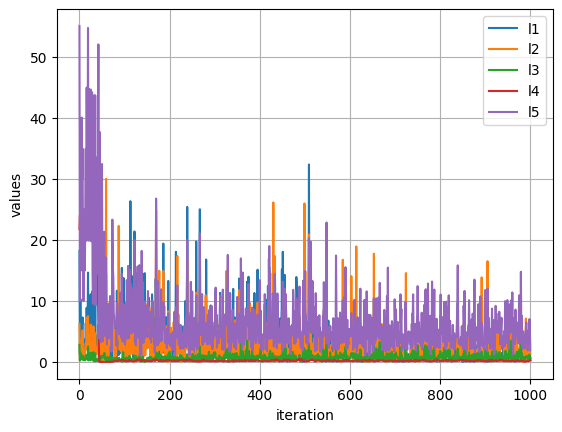

loss_df:               l1        l2        l3         l4         l5
0     10.717382  5.883269  1.297581  21.976810  49.960247
1      9.568982  6.095488  2.180096  20.955067  70.016190
2      5.839625  2.835721  1.017619  22.183887  45.016064
3      2.680056  1.043429  0.407189  23.663776  14.996277
4      7.906982  3.416750  1.189270  22.642963  34.993492
...         ...       ...       ...        ...        ...
996    2.123601  0.962829  0.925014   0.127247   2.904032
997    2.165015  8.302279  1.134444   0.209711   4.871050
998    6.399995  2.869617  1.163635   0.200856   4.403938
999    0.960394  0.635453  0.559078   0.218486   4.329367
1000   2.292186  1.646594  1.257133   0.260810   5.944741

[1001 rows x 5 columns]


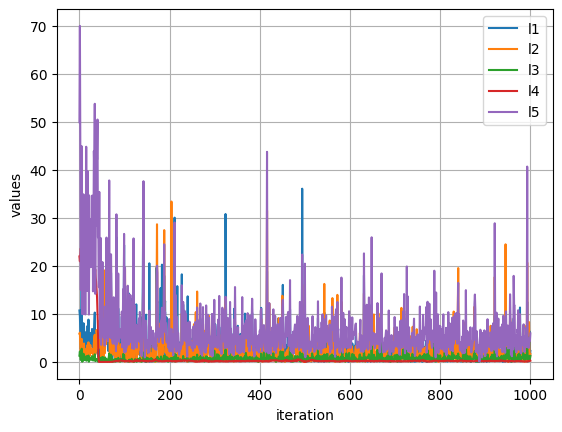

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
loss_dir = os.path.expanduser("~/YOLO_MODELS")
for fname in ["/train_loss_latest.csv", "/val_loss_latest.csv"]:
    loss_df = pd.read_csv(loss_dir + fname, index_col=0)
    print("loss_df: ", loss_df)
    for col in loss_df.columns:
        # if col == "l1" or col == "l2": #or col == "l5":
        plt.plot(loss_df[col], label=col)
    plt.xlabel("iteration")
    plt.ylabel("values")
    plt.legend()
    plt.grid(True)
    plt.show()